### Discussion 

Training the model took a long time so I had to change the max_epoch parameter a couple of times. The base model took almost 40 minutes to train on my local machine (max_epochs = 100). With a higher stride and capping the max_epochs at 80) I could bring that down to 20 minutes for some models. The more complex models still took 30-40 minutes. For higher speed, the implementation of wider models ResNet identity mapping, etc.. are is needed. 

In the following plots I will be discussing the results of my base models. 

Layout:
- (conv2-0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))  
- (relu-conv-0): ReLU()   
- (maxpool-0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
- (conv2-1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
- (relu-conv-1): ReLU()
- (flatten1): Flatten(start_dim=1, end_dim=-1)
- (fc-0): Linear(in_features=13456, out_features=120, bias=True)
- (Drop-0): Dropout(p=0, inplace=False)
- (relu-fc-0): ReLU()
- (fc-1): Linear(in_features=120, out_features=32, bias=True)
- (Drop-1): Dropout(p=0, inplace=False)
- (relu-fc-1): ReLU()
- (fc-2): Linear(in_features=32, out_features=8, bias=True)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
metrics_path = "trained_history/"
saved_models_path = "trained_models/"
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

   epoch  train_loss  train_accuracy  val_loss  val_accuracy
0     81  591.491760        0.376534  1.614679      0.395890
1     82  541.872314        0.429607  1.598058      0.403070
2     83  521.107605        0.451929  1.638787      0.384501
3     84  506.790192        0.466343  1.586085      0.402575
4     85  494.924683        0.479841  1.589217      0.396138


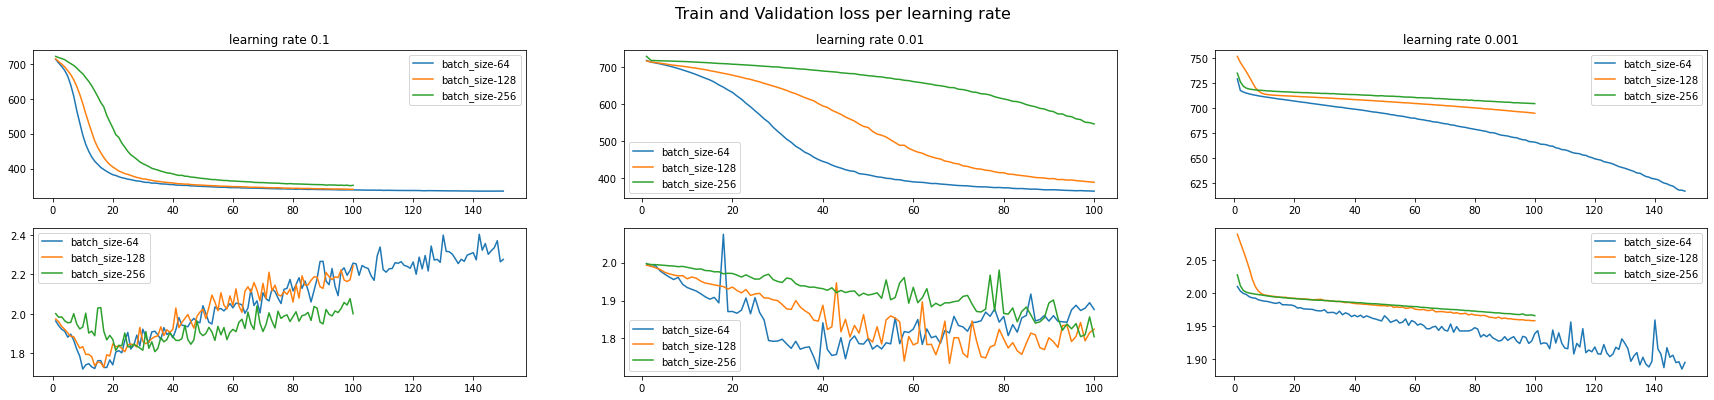

<Figure size 720x720 with 0 Axes>

In [2]:
params = [64, 128, 256]

lrs = [0.1, 0.01, 0.001]

df_a_3 = []
df_a_3_cnn2 = []

for lr in lrs:
    for param in params:
        df_a_3.append(pd.read_csv(metrics_path + "lr-" + str(lr) + "_batch_size-" + str(param) + ".csv"))

params_cnn2 = [64, 128]

lrs_cnn2 = [0.1, 0.01]

for lr in lrs_cnn2:
    for param in params_cnn2:
        df_a_3_cnn2.append(pd.read_csv(metrics_path + "lr-" + str(lr) + "_batch_size-" + str(param) + "-cnn2.csv"))
        
df_a_3_cnn2_extra = pd.read_csv(metrics_path + "lr-0.01_batch_size-64-cnn2-2.csv")
df_a_3_cnn2_extra.epoch = df_a_3_cnn2_extra.epoch + 80

print(df_a_3_cnn2_extra.head())
    
figure, axis = plt.subplots(2, 3)

figure.suptitle('Train and Validation loss per learning rate', fontsize=16)

axis[0, 0].set_title("learning rate 0.1")
axis[0, 1].set_title("learning rate 0.01")
axis[0, 2].set_title("learning rate 0.001")
plt.figure(figsize=(10, 10))

figure.set_figwidth(30)
figure.set_figheight(6)

for i in range(0,3):
    axis[0, i].plot(df_a_3[0+3*i].epoch, df_a_3[0+3*i].train_loss, label= "batch_size-64")
    axis[0, i].plot(df_a_3[1+3*i].epoch, 2*df_a_3[1+3*i].train_loss, label= "batch_size-128")
    axis[0, i].plot(df_a_3[2+3*i].epoch, 4*df_a_3[2+3*i].train_loss, label= "batch_size-256")
    axis[0, i].legend()

for i in range(0,3):
    axis[1, i].plot(df_a_3[0+3*i].epoch, df_a_3[0+3*i].val_loss, label= "batch_size-64")
    axis[1, i].plot(df_a_3[1+3*i].epoch, df_a_3[1+3*i].val_loss, label= "batch_size-128")
    axis[1, i].plot(df_a_3[2+3*i].epoch, df_a_3[2+3*i].val_loss, label= "batch_size-256")
    axis[1, i].legend()

plt.show()

In the plot above we can see the results of the basic model. The model was trained with lr = 0.1, 0.01 and 0.001 and batch sizes = 64, 128 and 256. The first three plots show the train loss of the model while the last three plots show the validation loss. To compare the training loss curve I multiplied the losses by 2^1 or 2^2 depending on the batch size.

As we can see, the result for the learning rate 0.1 looks the "best" as the model has learned a significant amount at the 100th epoch. For higher learning rates the model doesn't learn quickly enough to converge to a stagnating loss. A smaller learning rate might increase the accuracy overall but it might take a lot longer to do so. The curve is definitely smoother though. In future plots I will be using lr = 0.1 and batch size = 64 as the base model.

Larger batch sizes might produce "sharper" minima which require larger learning rates. 

The validation loss does increase even though the validation accuracy is also increasing. Those two metrics should be somewhat inversely correlated. According to the first answer here: https://stats.stackexchange.com/questions/282160/how-is-it-possible-that-validation-loss-is-increasing-while-validation-accuracy this phenomenon is quite normal. This can be due to bad predictions being predicted even worse after the network has trained for a certain amount of time thus making the cross-entropy loss explode. The same answer theorizes that if the validation loss is increasing the model might be starting to overfit.  

Let's see what the training accuracy looks like: 

#### Train/val accuracy base model

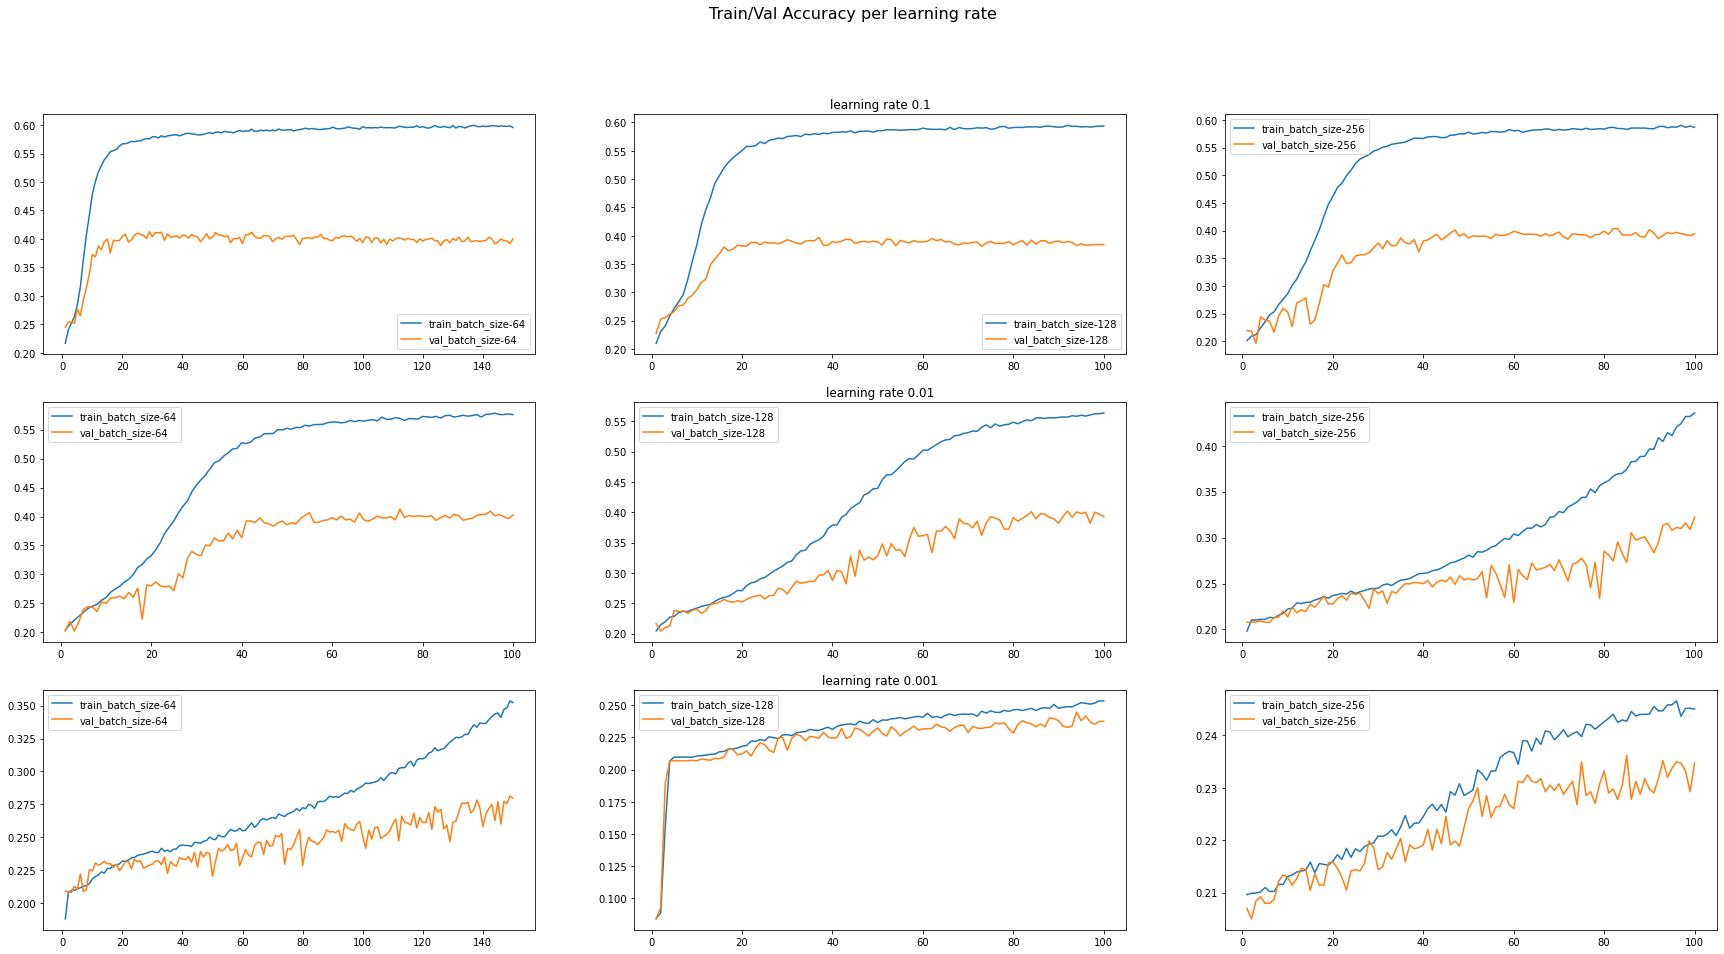

In [3]:
figure, axis = plt.subplots(3, 3)

figure.suptitle('Train/Val Accuracy per learning rate', fontsize=16)

axis[0, 1].set_title("learning rate 0.1")
axis[1, 1].set_title("learning rate 0.01")
axis[2, 1].set_title("learning rate 0.001")

figure.set_figwidth(30)
figure.set_figheight(15)

for i in range(0,3):
    for j in range(0,3):
        axis[i, j].plot(df_a_3[3*i+j].epoch, df_a_3[3*i+j].train_accuracy, label= "train_batch_size-"+str(params[j]))
        axis[i, j].plot(df_a_3[3*i+j].epoch, df_a_3[3*i+j].val_accuracy, label= "val_batch_size-"+str(params[j]))            
        
        axis[i, j].legend()  

plt.show()

The accuracies show that the models with lr = 0.1 start to overfit the data by the 60th - 80th epoch. The train accuracy increases but the validation accuracy doesn't. The plots also show that smaller batch sizes might generalize better as the validation accuracy is higher for smaller batch sizes. On the other hand, the validation accuracy moves much closer with the train accuracy with smaller learning rates. This could mean that a smaller learning rate might generalize better.

#### Train/val accuracy for second cnn compared to base model

(100, 5)


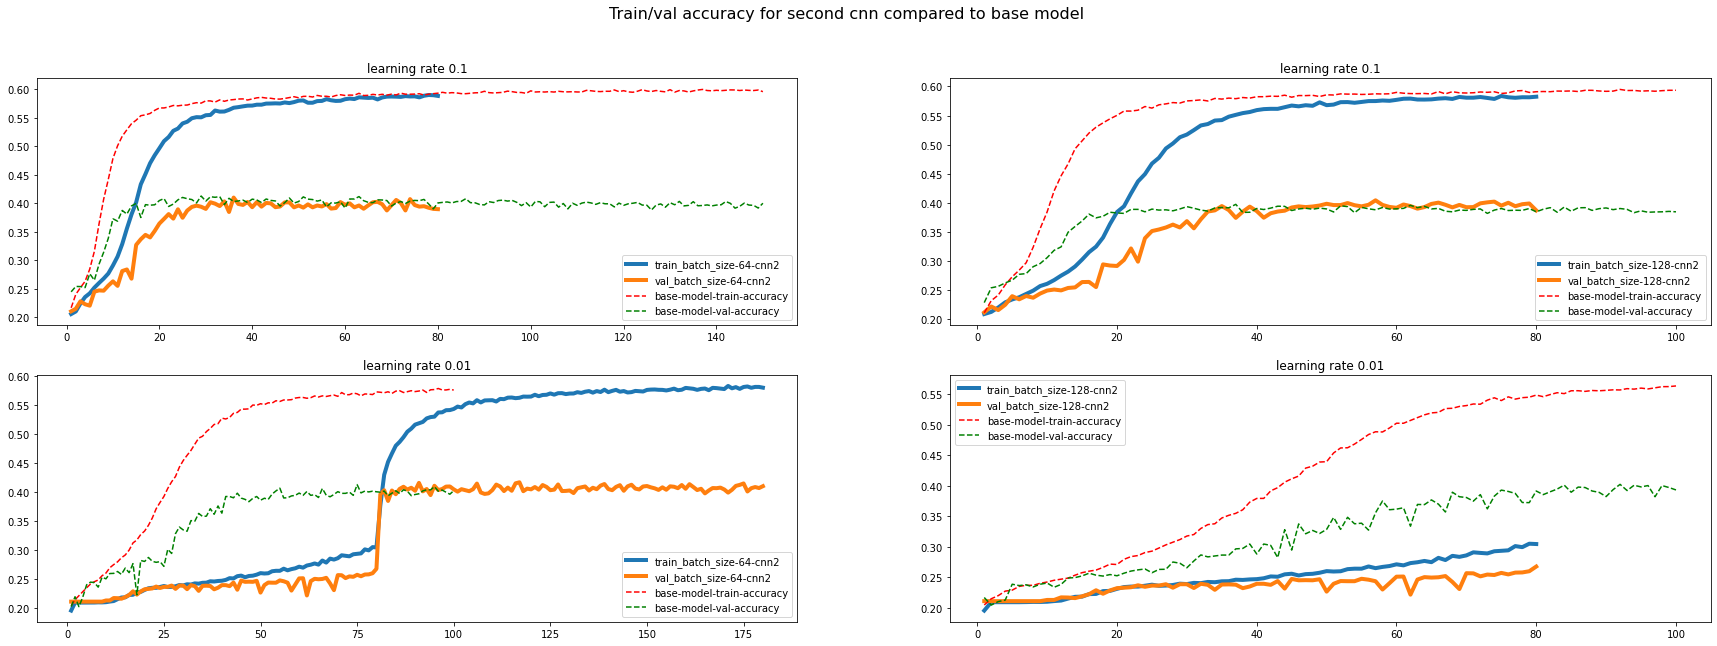

In [4]:
figure, axis = plt.subplots(2, 2)

figure.suptitle('Train/val accuracy for second cnn compared to base model', fontsize=16)

axis[0, 0].set_title("learning rate 0.1")
axis[0, 1].set_title("learning rate 0.1")
axis[1, 0].set_title("learning rate 0.01")
axis[1, 1].set_title("learning rate 0.01")

figure.set_figwidth(30)
figure.set_figheight(10)

print(df_a_3[3].shape)

df_a_3_cnn2[2] = pd.concat([df_a_3_cnn2[3], df_a_3_cnn2_extra])

for i in range(0,2):
    for j in range(0,2): 
            axis[i, j].plot(df_a_3_cnn2[2*i+j].epoch, df_a_3_cnn2[2*i+j].train_accuracy, label= "train_batch_size-"+str(params[j]) + "-cnn2", linewidth=4)
            axis[i, j].plot(df_a_3_cnn2[2*i+j].epoch, df_a_3_cnn2[2*i+j].val_accuracy, label= "val_batch_size-"+str(params[j]) + "-cnn2", linewidth=4)
            axis[i, j].plot(df_a_3[3*i+j].epoch, df_a_3[3*i+j].train_accuracy, 'r--', label= "base-model-train-accuracy")
            axis[i, j].plot(df_a_3[3*i+j].epoch, df_a_3[3*i+j].val_accuracy, 'g--', label= "base-model-val-accuracy") 
            
            axis[i, j].legend()
        
plt.show()

The plot above compares the train and validation accuracy of the basic CNN model with a second CNN model with one additional convolutional layer and one additional fully connected layer:

- (conv2-0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
- (relu-conv-0): ReLU()
- (maxpool-0): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
- (conv2-1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
- (relu-conv-1): ReLU()
- (maxpool-1): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
- (conv2-2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
- (relu-conv-2): ReLU()
- (flatten1): Flatten(start_dim=1, end_dim=-1)
- (fc-0): Linear(in_features=1600, out_features=240, bias=True)
- (Drop-0): Dropout(p=0, inplace=False)
- (relu-fc-0): ReLU()
- (fc-1): Linear(in_features=240, out_features=120, bias=True)
- (Drop-1): Dropout(p=0, inplace=False)
- (relu-fc-1): ReLU()
- (fc-2): Linear(in_features=120, out_features=32, bias=True)
- (Drop-2): Dropout(p=0, inplace=False)
- (relu-fc-2): ReLU()
- (fc-3): Linear(in_features=32, out_features=8, bias=True)

For the setup with lr = 0.01 and batch size = 64, I stopped the training halfway through and resumed after a while. This resulted in an unconnected graph. I have no idea why after loading the model and restarting the training, the accuracy jumped. I might have missed an important setting to load the model. This model was not much of an improvement over the base model anyway.  

In general, the results don't show a noteworthy improvement in prediction accuracy over the simpler model. There might be a 1% improvement. This might be due to several different reasons. An increased model depth might make the network harder to optimize because the loss surface becomes less smooth. Adding skip-connections and other sophisticated methods might help. The input could also hold too little information so that adding another convolutional layer doesn't improve the accuracy as there is no more information to be gained from the images. Also, the filters and pooling layers might not suit the images. I think adding data augmentation would improve the model by a significant amount because the images look very similar.

#### Bigger CNN Kernel Size vs Padding 2 vs Stride 3 vs everything combined

Kernel size is the filter size of the convolution. It determines the size of the extracted features from the image. 

Padding adds another dimension of pixels to the input image. This is because filtering through the input image might be tricky on the edge of the image. This leads to a higher output size which makes calculation slower.

Stride adds a skipping motion to the filter. Normally a filter jumps pixel by pixel until it reaches the edge of the image. With stride it goes skips x amount of pixels per jump. This can lead to faster calculation speed.

Both padding and stride can be used to adjust dimensionality of the data. This can be useful in audio data. (I think)

There are also different methods for pooling the pixels of input data into a smaller output. In this project I used maxpooling to decrease training time.

In [5]:
df_a_3_kernel_5 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-kernel-5.csv")
df_a_3_padding_2 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-padding-2.csv")
df_a_3_stride_3 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-stride-3.csv")
df_a_3_alles = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-aufgabe3-alles.csv")

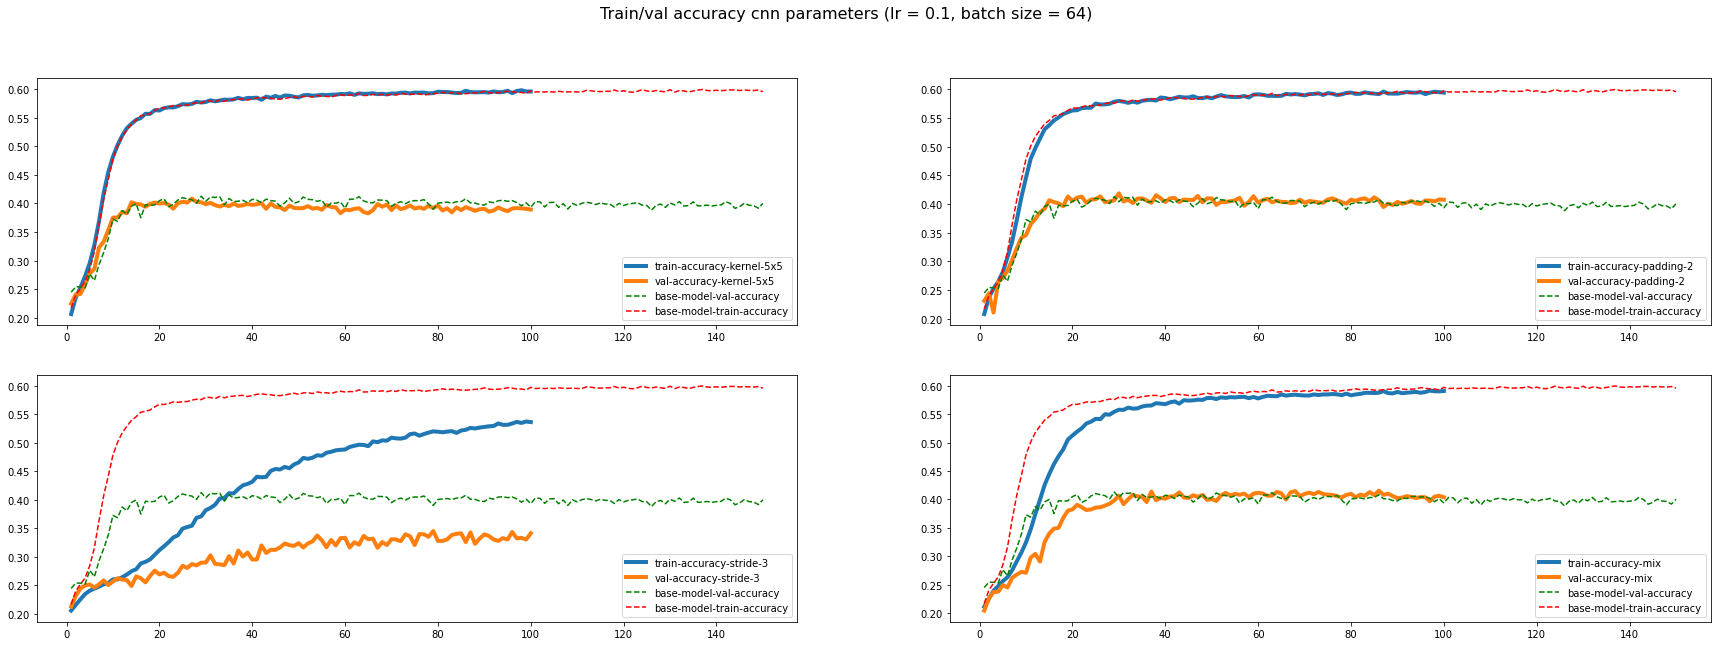

In [6]:
figure, axis = plt.subplots(2, 2)

figure.suptitle('Train/val accuracy cnn parameters (lr = 0.1, batch size = 64)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0, 0].plot(df_a_3_kernel_5.epoch, df_a_3_kernel_5.train_accuracy, label= "train-accuracy-kernel-5x5", linewidth=4)
axis[0, 0].plot(df_a_3_kernel_5.epoch, df_a_3_kernel_5.val_accuracy, label= "val-accuracy-kernel-5x5", linewidth=4)
axis[0, 1].plot(df_a_3_padding_2.epoch, df_a_3_padding_2.train_accuracy, label= "train-accuracy-padding-2", linewidth=4)
axis[0, 1].plot(df_a_3_padding_2.epoch, df_a_3_padding_2.val_accuracy, label= "val-accuracy-padding-2", linewidth=4)
axis[1, 0].plot(df_a_3_stride_3.epoch, df_a_3_stride_3.train_accuracy, label= "train-accuracy-stride-3", linewidth=4)
axis[1, 0].plot(df_a_3_stride_3.epoch, df_a_3_stride_3.val_accuracy, label= "val-accuracy-stride-3", linewidth=4)
axis[1, 1].plot(df_a_3_alles.epoch, df_a_3_alles.train_accuracy, label= "train-accuracy-mix", linewidth=4)
axis[1, 1].plot(df_a_3_alles.epoch, df_a_3_alles.val_accuracy, label= "val-accuracy-mix", linewidth=4)
            
    
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy")    
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy")    
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy") 

axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
        
plt.show()

In the series above the kernel size, padding and stride settings were changed in both convolutional layers simultaneously.

The first plot shows the comparison of a base model with a model with a higher kernel size. The model doesn't improve and is actually worse by ~2%. This means 5x5 filters don't capture information in the picture any better than 3x3 filters. They might miss more information even. Later I will plot the results of a model with kernel sizes (5x5, 3x3 and 1x1) with 3 convolutional layers respectively.

The second plot shows the result of a model with padding. The idea of padding is to capture information at the edges of a picture. In our case, this hasn't improved the model. 

The third plot shows the result of training the same model with stride 3. The model learns too slow with this setting. Since the kernel size is small (3x3), stride 3 might make the filter jump too much. 

Combining all three settings, the model actually improves by roughly 1%. This might be due to the fact that stride now has more pixels to skip. The bigger kernel size might also benefit from these settings. 

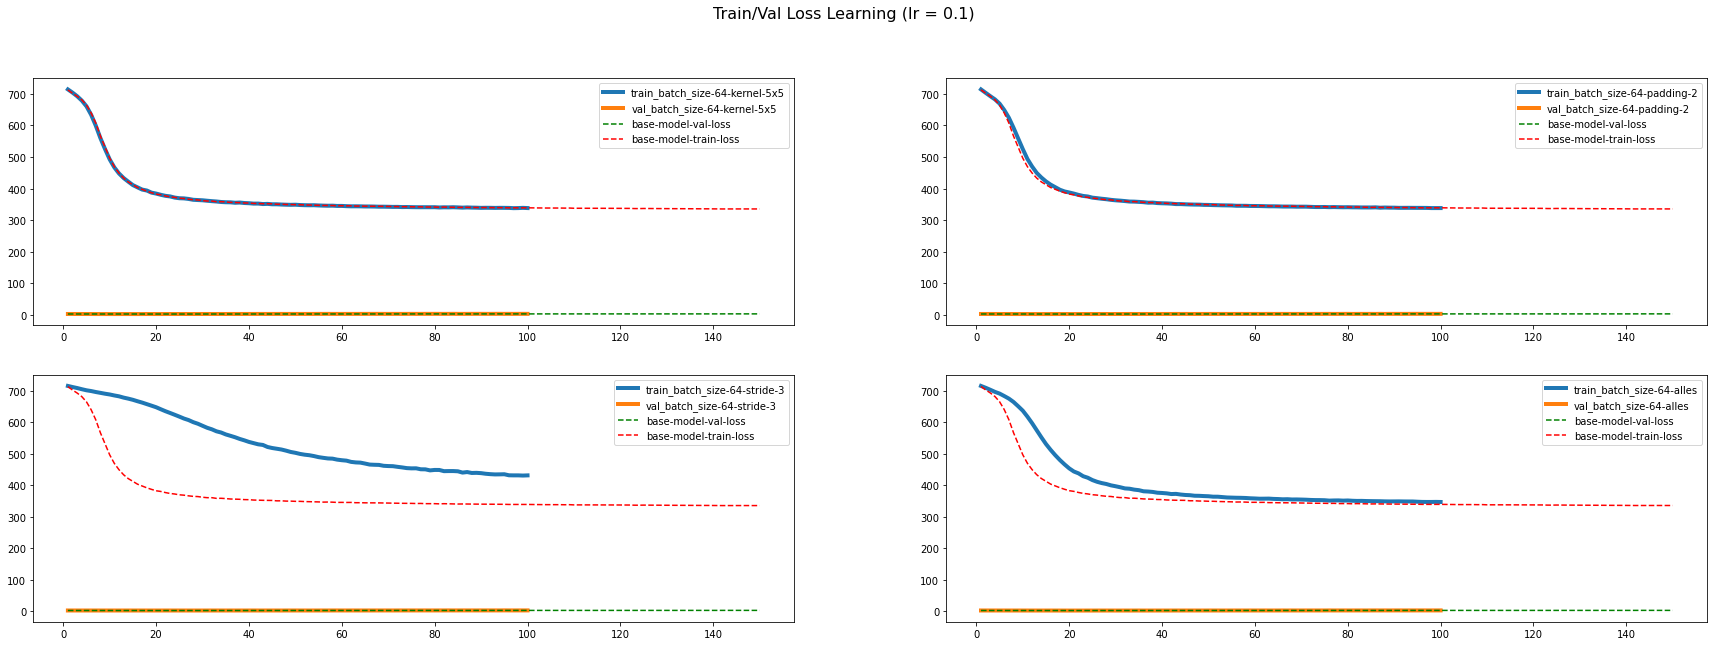

In [7]:
df_a_3_kernel_5
df_a_3_padding_2
df_a_3_stride_3
df_a_3_alles

figure, axis = plt.subplots(2, 2)

figure.suptitle('Train/Val Loss Learning (lr = 0.1)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0, 0].plot(df_a_3_kernel_5.epoch, df_a_3_kernel_5.train_loss, label= "train_batch_size-64-kernel-5x5", linewidth=4)
axis[0, 0].plot(df_a_3_kernel_5.epoch, df_a_3_kernel_5.val_loss, label= "val_batch_size-64-kernel-5x5", linewidth=4)
axis[0, 1].plot(df_a_3_padding_2.epoch, df_a_3_padding_2.train_loss, label= "train_batch_size-64-padding-2", linewidth=4)
axis[0, 1].plot(df_a_3_padding_2.epoch, df_a_3_padding_2.val_loss, label= "val_batch_size-64-padding-2", linewidth=4)
axis[1, 0].plot(df_a_3_stride_3.epoch, df_a_3_stride_3.train_loss, label= "train_batch_size-64-stride-3", linewidth=4)
axis[1, 0].plot(df_a_3_stride_3.epoch, df_a_3_stride_3.val_loss, label= "val_batch_size-64-stride-3", linewidth=4)
axis[1, 1].plot(df_a_3_alles.epoch, df_a_3_alles.train_loss, label= "train_batch_size-64-alles", linewidth=4)
axis[1, 1].plot(df_a_3_alles.epoch, df_a_3_alles.val_loss, label= "val_batch_size-64-alles", linewidth=4)
            
    
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].val_loss, 'g--', label= "base-model-val-loss")    
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss")    
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 

axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
        
plt.show()

#### More Models

In [8]:
df_a_3_more_neurons = pd.read_csv(metrics_path + "lr-0.01_batch_size-64-more_neurons.csv")
df_a_3_kernel_5_3_1 = pd.read_csv(metrics_path + "lr-0.01_batch_size-64-kernel-5-3-1.csv")

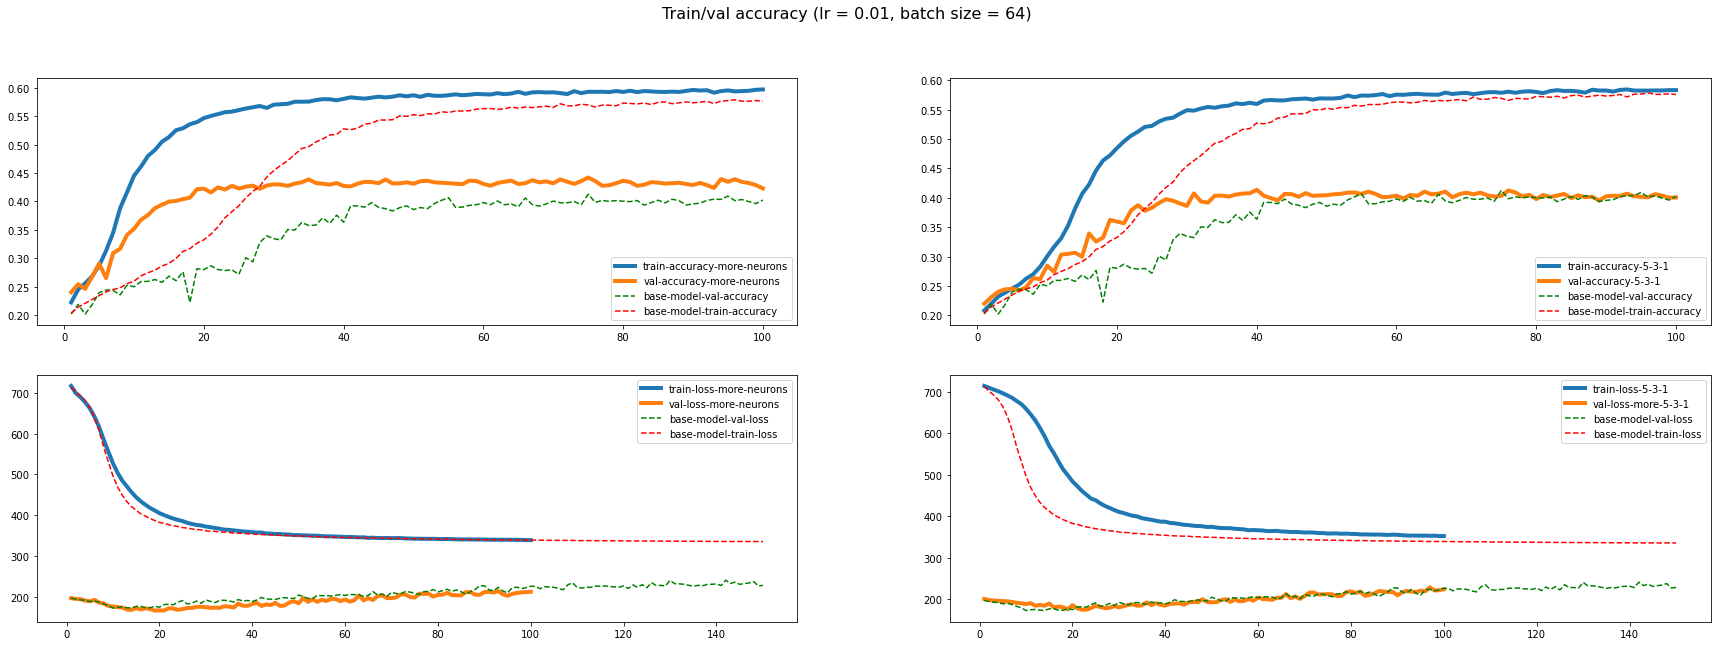

In [9]:
figure, axis = plt.subplots(2, 2)

figure.suptitle('Train/val accuracy (lr = 0.01, batch size = 64)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0, 0].plot(df_a_3_more_neurons.epoch, df_a_3_more_neurons.train_accuracy, label= "train-accuracy-more-neurons", linewidth=4)
axis[0, 0].plot(df_a_3_more_neurons.epoch, df_a_3_more_neurons.val_accuracy, label= "val-accuracy-more-neurons", linewidth=4)

axis[0, 1].plot(df_a_3_kernel_5_3_1.epoch, df_a_3_kernel_5_3_1.train_accuracy, label= "train-accuracy-5-3-1", linewidth=4)
axis[0, 1].plot(df_a_3_kernel_5_3_1.epoch, df_a_3_kernel_5_3_1.val_accuracy, label= "val-accuracy-5-3-1", linewidth=4)

axis[1, 0].plot(df_a_3_more_neurons.epoch, df_a_3_more_neurons.train_loss, label= "train-loss-more-neurons", linewidth=4)
axis[1, 0].plot(df_a_3_more_neurons.epoch, 100*df_a_3_more_neurons.val_loss, label= "val-loss-more-neurons", linewidth=4)
axis[1, 1].plot(df_a_3_kernel_5_3_1.epoch, df_a_3_kernel_5_3_1.train_loss, label= "train-loss-5-3-1", linewidth=4)
axis[1, 1].plot(df_a_3_kernel_5_3_1.epoch, 100*df_a_3_kernel_5_3_1.val_loss, label= "val-loss-more-5-3-1", linewidth=4)
            
    
axis[0, 0].plot(df_a_3[3].epoch, df_a_3[3].val_accuracy, 'g--', label= "base-model-val-accuracy")    
axis[0, 1].plot(df_a_3[3].epoch, df_a_3[3].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[1, 0].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[1, 1].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[0, 0].plot(df_a_3[3].epoch, df_a_3[3].train_accuracy,'r--', label= "base-model-train-accuracy")    
axis[0, 1].plot(df_a_3[3].epoch, df_a_3[3].train_accuracy,'r--', label= "base-model-train-accuracy") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 

axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
        
plt.show()

Two additional models (lr = 0.01 and batch size = 64) were compared with the base model (lr = 0.1 and batch size = 64). The first model seen on the left saw an improvement of about 2-3% due to more neurons (2000) in the second fully connected layer. Surprisingly, adding a more sophisticated CNN setup (3 convolutional layers with kernel size 5, 3 and 1 respectively) resulted in no improvement. This means the simpler base model convolutions recognize a good amount of features from the images but there are probably too few connections in the linear layers to make the model more robust. 

Interesting is the fact, that even though the model's accuracy improved much quicker in the first couple of epochs, the loss is actually higher for both of the models. Does this mean that the more sophisticated model is misclassifying images and applying a higher "cost" to it than the base model?

#### Regularization

Regularization adds another element to the loss function which penalizes big weights. The model trains on the training data set which differs from the validation or test data set. It's sometimes preferable to keep the weights from getting too "comfortable" with the training set so that the model generalizes better for the test data set. This is can be done by penalizing them by adding a sum of all the weights to the loss function so that no weight gets too big (= comfortable). This makes the model overfit less.

The L2 regularization or weight_decay parameter in the optimization object in pytorch adds a sum of squared weight values to the loss function while L1 regularization adds the sum of absolute weight values. 

Another regularization technique is dropout. Each neuron is given a probability of being dropped from the model. This is equivalent to dropping a row in the weight matrix of a hidden layer. This results in individual neurons being more robust which make the model generalize better. 

In [10]:
df_a_4_l1_0_0001 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-l1-0.0001.csv")
df_a_4_l1_0_001 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-l1-0.001.csv")
df_a_4_l2_0_01 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-l2-0.01.csv")
df_a_4_l2_0_1 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-l2-0.1.csv")

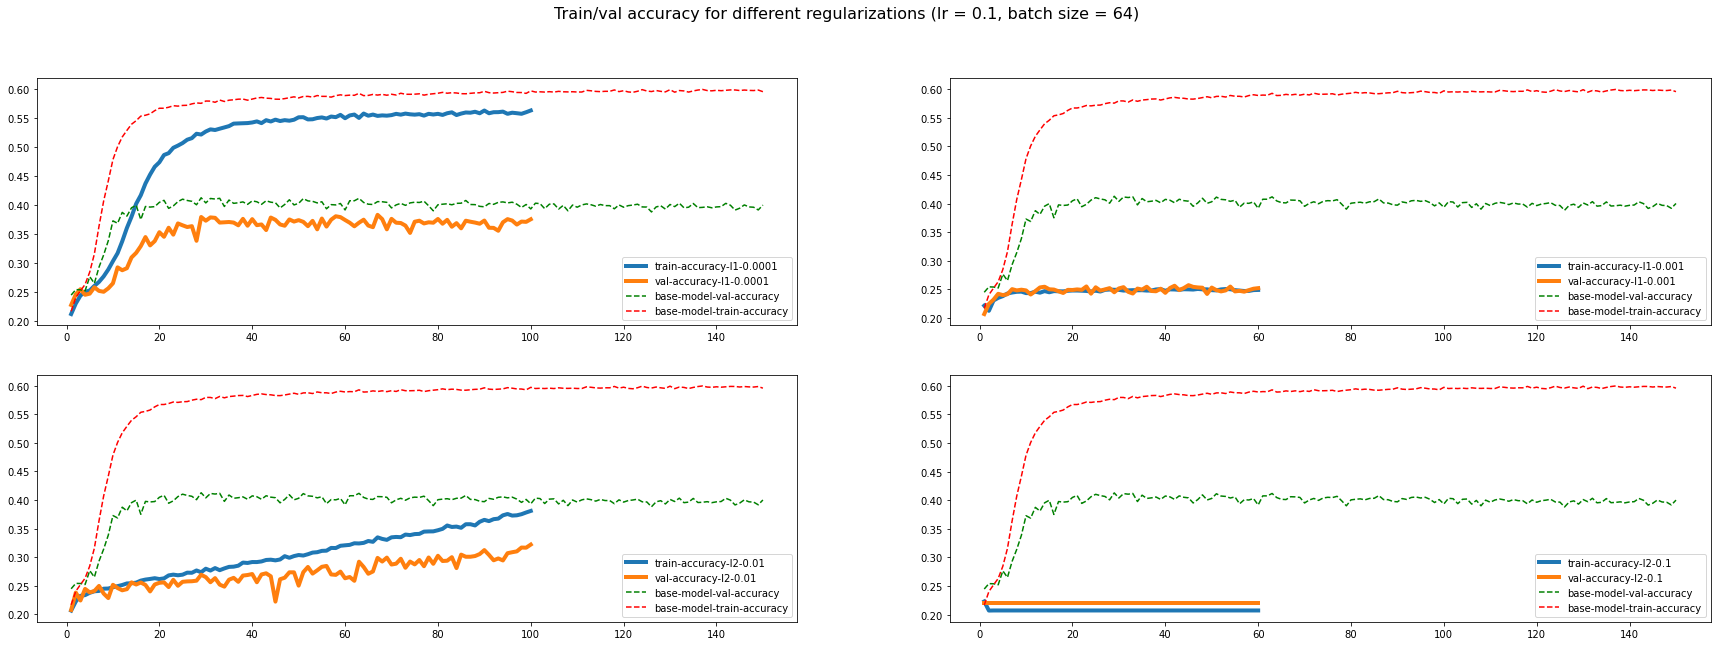

In [11]:
figure, axis = plt.subplots(2, 2)

figure.suptitle('Train/val accuracy for different regularizations (lr = 0.1, batch size = 64)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0, 0].plot(df_a_4_l1_0_0001.epoch, df_a_4_l1_0_0001.train_accuracy, label= "train-accuracy-l1-0.0001", linewidth=4)
axis[0, 0].plot(df_a_4_l1_0_0001.epoch, df_a_4_l1_0_0001.val_accuracy, label= "val-accuracy-l1-0.0001", linewidth=4)
axis[0, 1].plot(df_a_4_l1_0_001.epoch, df_a_4_l1_0_001.train_accuracy, label= "train-accuracy-l1-0.001", linewidth=4)
axis[0, 1].plot(df_a_4_l1_0_001.epoch, df_a_4_l1_0_001.val_accuracy, label= "val-accuracy-l1-0.001", linewidth=4)
axis[1, 0].plot(df_a_4_l2_0_01.epoch, df_a_4_l2_0_01.train_accuracy, label= "train-accuracy-l2-0.01", linewidth=4)
axis[1, 0].plot(df_a_4_l2_0_01.epoch, df_a_4_l2_0_01.val_accuracy, label= "val-accuracy-l2-0.01", linewidth=4)
axis[1, 1].plot(df_a_4_l2_0_1.epoch, df_a_4_l2_0_1.train_accuracy, label= "train-accuracy-l2-0.1", linewidth=4)
axis[1, 1].plot(df_a_4_l2_0_1.epoch, df_a_4_l2_0_1.val_accuracy, label= "val-accuracy-l2-0.1", linewidth=4)
            
    
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy")    
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy,'g--', label= "base-model-val-accuracy") 
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy")    
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy") 
axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy") 

axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
        
plt.show()

Adding regularization penalizes the model which tends to decrease the training accuracy. Typically this is accompanied by better generalization. We can see this effect in all of the plots above since all of them show the train and validation accuracy closer together. The penalization seems to be too harsh for all of the models, so maybe l2 = 0.001 does a better job?

In [12]:
df_a_4_l2_0_001 = pd.read_csv(metrics_path + "lr-0.01_batch_size-64-l2-0.001.csv")

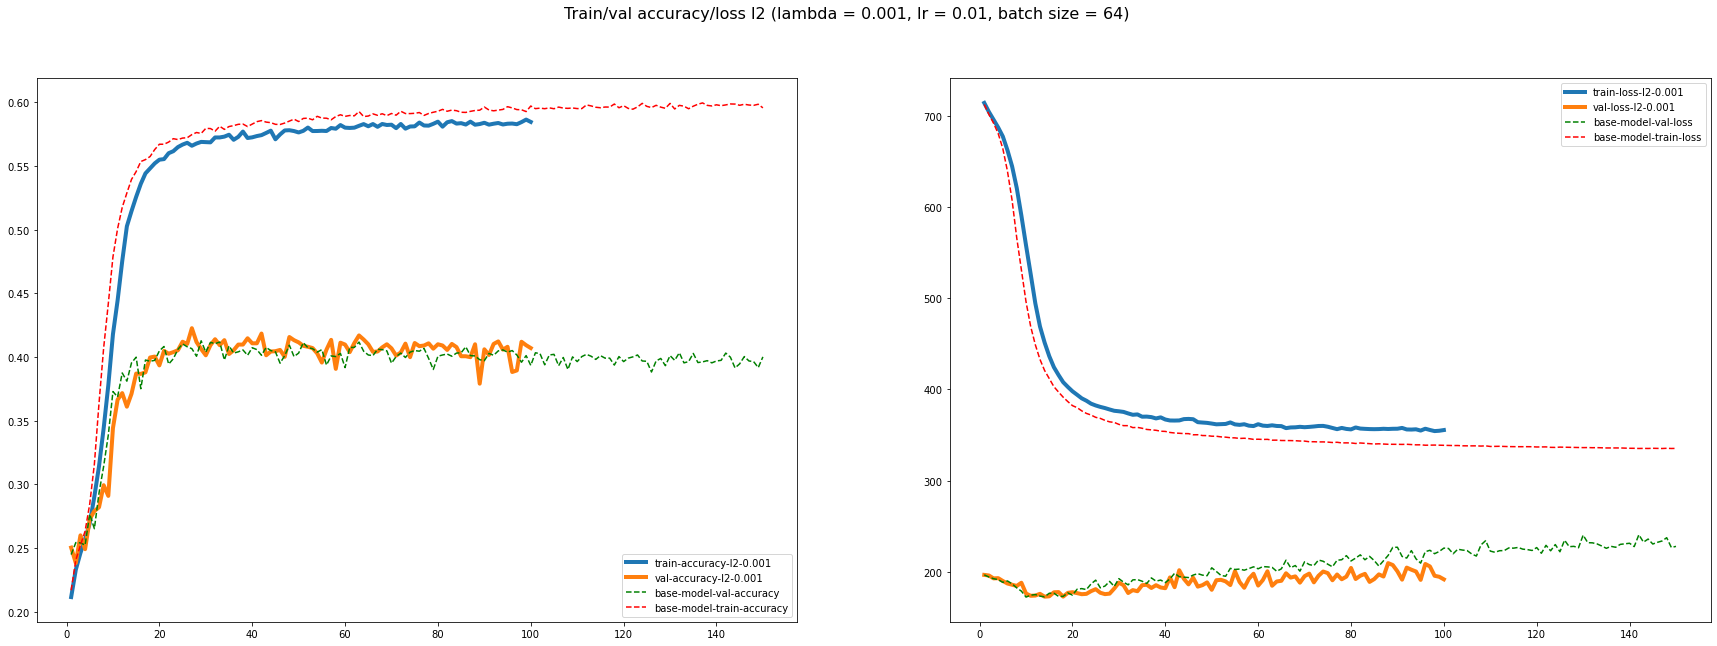

In [13]:
figure, axis = plt.subplots(1, 2)

figure.suptitle('Train/val accuracy/loss l2 (lambda = 0.001, lr = 0.01, batch size = 64)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0].plot(df_a_4_l2_0_001.epoch, df_a_4_l2_0_001.train_accuracy, label= "train-accuracy-l2-0.001", linewidth=4)
axis[0].plot(df_a_4_l2_0_001.epoch, df_a_4_l2_0_001.val_accuracy, label= "val-accuracy-l2-0.001", linewidth=4)
    
axis[0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy") 
axis[0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy, 'r--', label= "base-model-train-accuracy")

axis[1].plot(df_a_4_l2_0_001.epoch, df_a_4_l2_0_001.train_loss, label= "train-loss-l2-0.001", linewidth=4)
axis[1].plot(df_a_4_l2_0_001.epoch, 100*df_a_4_l2_0_001.val_loss, label= "val-loss-l2-0.001", linewidth=4)
            
axis[1].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss, 'g--', label= "base-model-val-loss") 
axis[1].plot(df_a_3[0].epoch, df_a_3[0].train_loss, 'r--', label= "base-model-train-loss")


axis[0].legend()
axis[1].legend()

plt.show()

A slightly smaller l2 rate makes the model slightly less overfit. The improvement in validation accuracy is slim, maybe because there are not enough fully connected layer neurons to penalize(?). The validation loss has actually deceased. I don't exactly know why.

##### Dropout

In [14]:
df_a_4_drop_0_5 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-dropout-0.5.csv")
df_a_4_drop_0_25 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-dropout-0.25.csv")
df_a_4_drop_0_1 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-dropout-0.1.csv")

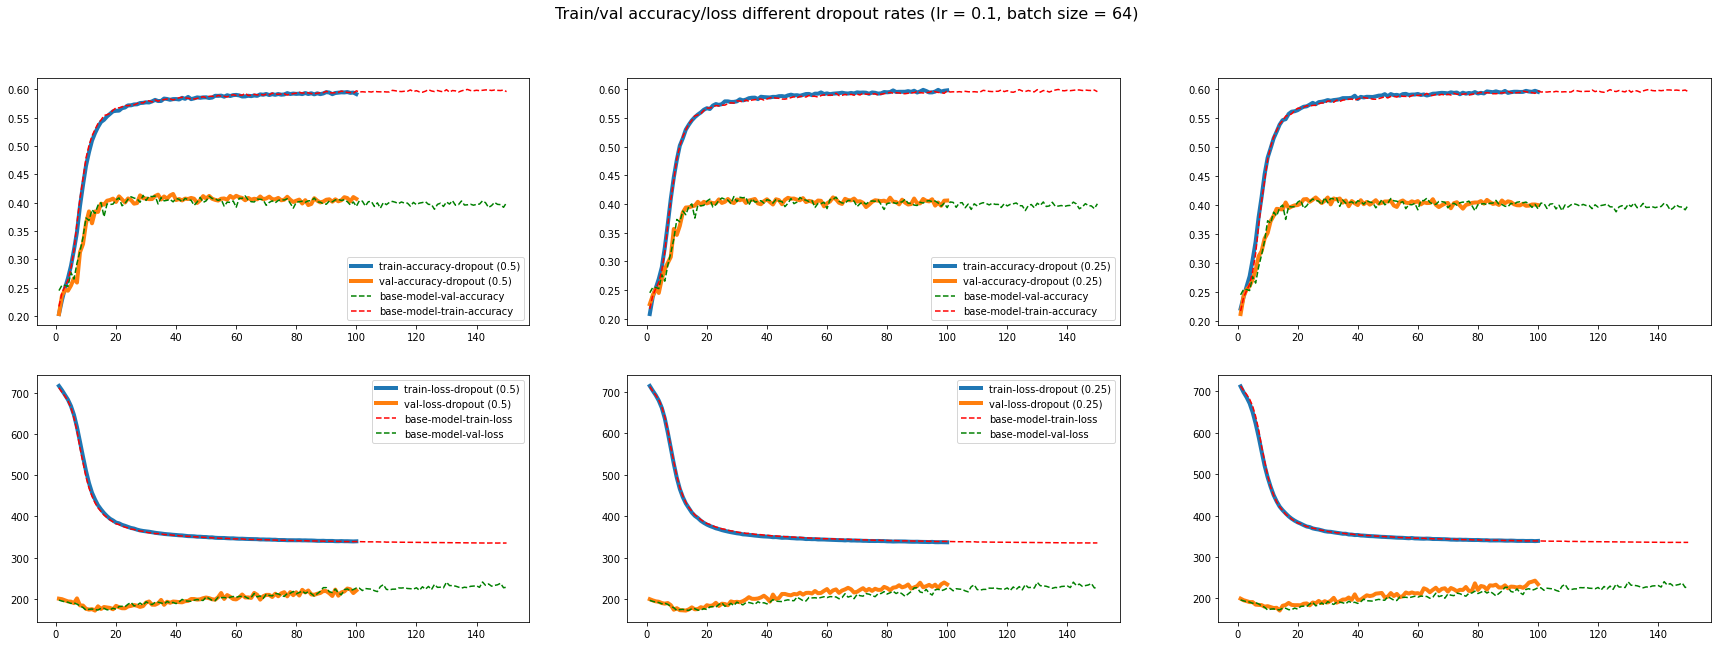

In [15]:
figure, axis = plt.subplots(2, 3)

figure.suptitle('Train/val accuracy/loss different dropout rates (lr = 0.1, batch size = 64)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0, 0].plot(df_a_4_drop_0_5.epoch, df_a_4_drop_0_5.train_accuracy, label= "train-accuracy-dropout (0.5)", linewidth=4)
axis[0, 0].plot(df_a_4_drop_0_5.epoch, df_a_4_drop_0_5.val_accuracy, label= "val-accuracy-dropout (0.5)", linewidth=4)
axis[0, 1].plot(df_a_4_drop_0_25.epoch, df_a_4_drop_0_25.train_accuracy, label= "train-accuracy-dropout (0.25)", linewidth=4)
axis[0, 1].plot(df_a_4_drop_0_25.epoch, df_a_4_drop_0_25.val_accuracy, label= "val-accuracy-dropout (0.25)", linewidth=4)
axis[0, 2].plot(df_a_4_drop_0_1.epoch, df_a_4_drop_0_1.train_accuracy, label= "train-accuracy-dropout (0.1)", linewidth=4)
axis[0, 2].plot(df_a_4_drop_0_1.epoch, df_a_4_drop_0_1.val_accuracy, label= "val-accuracy-dropout (0.1)", linewidth=4)
axis[1, 0].plot(df_a_4_drop_0_5.epoch, df_a_4_drop_0_5.train_loss, label= "train-loss-dropout (0.5)", linewidth=4)
axis[1, 0].plot(df_a_4_drop_0_5.epoch, 100*df_a_4_drop_0_5.val_loss, label= "val-loss-dropout (0.5)", linewidth=4)
axis[1, 1].plot(df_a_4_drop_0_25.epoch, df_a_4_drop_0_25.train_loss, label= "train-loss-dropout (0.25)", linewidth=4)
axis[1, 1].plot(df_a_4_drop_0_25.epoch, 100*df_a_4_drop_0_25.val_loss, label= "val-loss-dropout (0.25)", linewidth=4)
axis[1, 2].plot(df_a_4_drop_0_1.epoch, df_a_4_drop_0_1.train_loss, label= "train-loss-dropout (0.1)", linewidth=4)
axis[1, 2].plot(df_a_4_drop_0_1.epoch, 100*df_a_4_drop_0_1.val_loss, label= "val-loss-dropout (0.1)", linewidth=4)
            
    
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy")   
axis[0, 0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy")   
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy")   
axis[0, 1].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy")
axis[0, 2].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy")   
axis[0, 2].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy,'r--', label= "base-model-train-accuracy")

axis[1, 0].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 
axis[1, 0].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[1, 1].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 
axis[1, 1].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 
axis[1, 2].plot(df_a_3[0].epoch, df_a_3[0].train_loss,'r--', label= "base-model-train-loss") 
axis[1, 2].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss,'g--', label= "base-model-val-loss") 

axis[0, 0].legend()
axis[0, 1].legend()
axis[1, 0].legend()
axis[1, 1].legend()
        
plt.show()

The dropout was applied to each fully connected layer but not to the input or the convolutions.

The regularizing effect of dropout is not substantial. There is definitely an effect with dropout = 0.5 as the model is not overfitting as much as in the base model. The validation accuracy doesn't change much though. 

#### Batchnorm

Batch norm is used to combat the vanishing gradient problem. When the model is trained, weights are getting updated and they might adopt a value that is not compatible to the activation function (maybe too high/low). Furthermore, the gradients become smaller and smaller when backpropagating from last hidden layer to first hidden layer. Using adequate parameter initialization, suitable activation functions and batch normalization combats this problem.

batch normalization normalizes every weight with an estimate of the mean and the standard deviation of the current mini-batch before being passed to the activation function. This makes the weight compatible with the activation function. 

In [16]:
df_a_5_BN_64 = pd.read_csv(metrics_path + "lr-0.1_batch_size-64-dropout-0.5.csv")

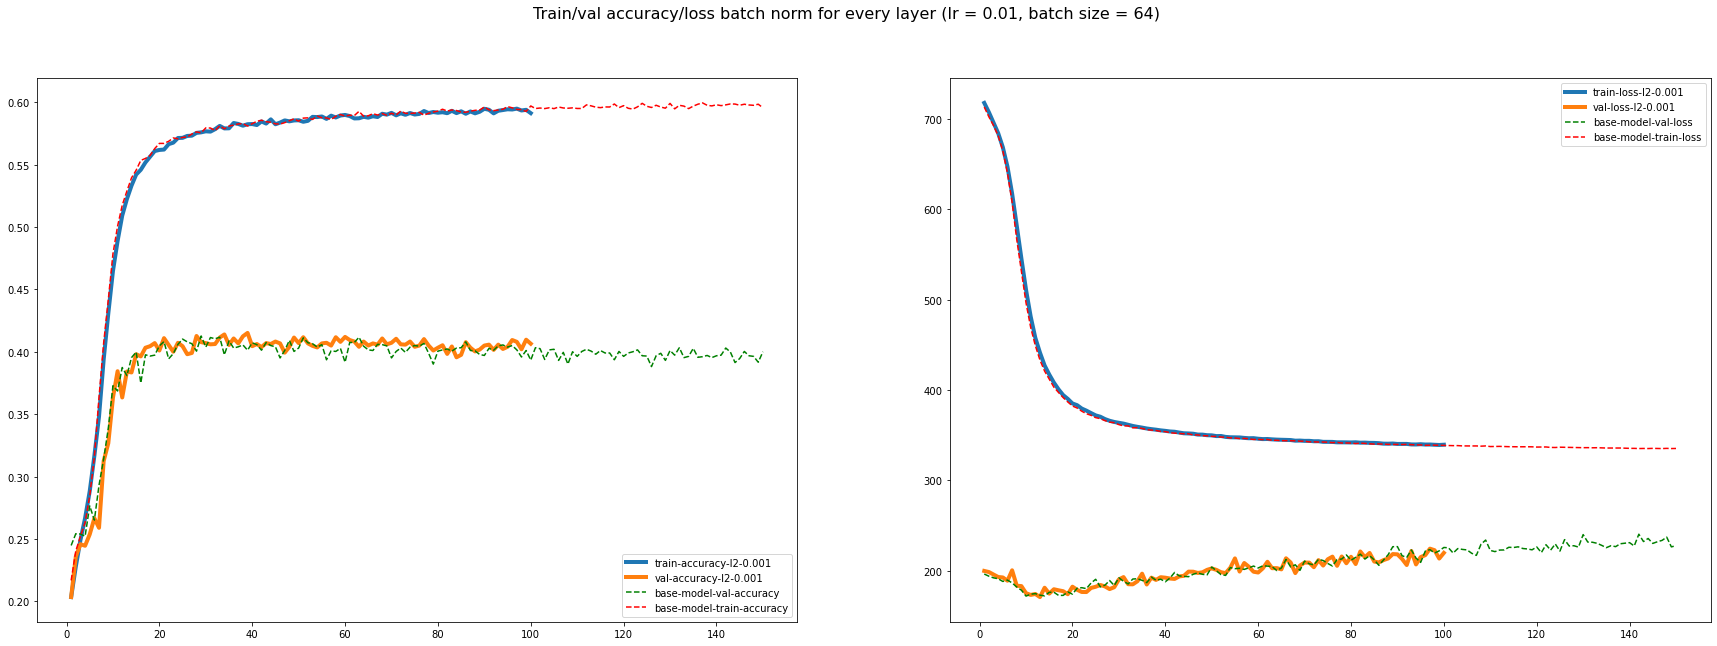

In [17]:
figure, axis = plt.subplots(1, 2)

figure.suptitle('Train/val accuracy/loss batch norm for every layer (lr = 0.01, batch size = 64)', fontsize=16)

figure.set_figwidth(30)
figure.set_figheight(10)

axis[0].plot(df_a_5_BN_64.epoch, df_a_5_BN_64.train_accuracy, label= "train-accuracy-l2-0.001", linewidth=4)
axis[0].plot(df_a_5_BN_64.epoch, df_a_5_BN_64.val_accuracy, label= "val-accuracy-l2-0.001", linewidth=4)
    
axis[0].plot(df_a_3[0].epoch, df_a_3[0].val_accuracy, 'g--', label= "base-model-val-accuracy") 
axis[0].plot(df_a_3[0].epoch, df_a_3[0].train_accuracy, 'r--', label= "base-model-train-accuracy")

axis[1].plot(df_a_5_BN_64.epoch, df_a_5_BN_64.train_loss, label= "train-loss-l2-0.001", linewidth=4)
axis[1].plot(df_a_5_BN_64.epoch, 100*df_a_5_BN_64.val_loss, label= "val-loss-l2-0.001", linewidth=4)
            
axis[1].plot(df_a_3[0].epoch, 100*df_a_3[0].val_loss, 'g--', label= "base-model-val-loss") 
axis[1].plot(df_a_3[0].epoch, df_a_3[0].train_loss, 'r--', label= "base-model-train-loss")


axis[0].legend()
axis[1].legend()

plt.show()

Batch norm was applied to every hidden layer of the network and it was done before the activation function. Batch norm should have a small regularization effect as well as fix the vanishing gradient problem as the weights are stabilized to pass through the next activation function. Another effect of batch norm is faster and better convergence to a stagnating accuracy/loss. This was not achieved with my model. The effects of batch normalization might be greater on deeper models.

#### Adam Optimizer

In [18]:
params_6 = [64, 128]

lrs_6 = [0.01, 0.001, 0.0001]

df_a_6 = []
df_a_6_l2_batch_64 = pd.read_csv(metrics_path + "lr-0.001_batch_size-64-adam-l2-0.001.csv")
df_a_6_l2_batch_128 = pd.read_csv(metrics_path + "lr-0.001_batch_size-128-adam-l2-0.001.csv")

for lr in lrs_6:
    for param in params_6:
        df_a_6.append(pd.read_csv(metrics_path + "lr-" + str(lr) + "_batch_size-" + str(param) + "-adam.csv"))

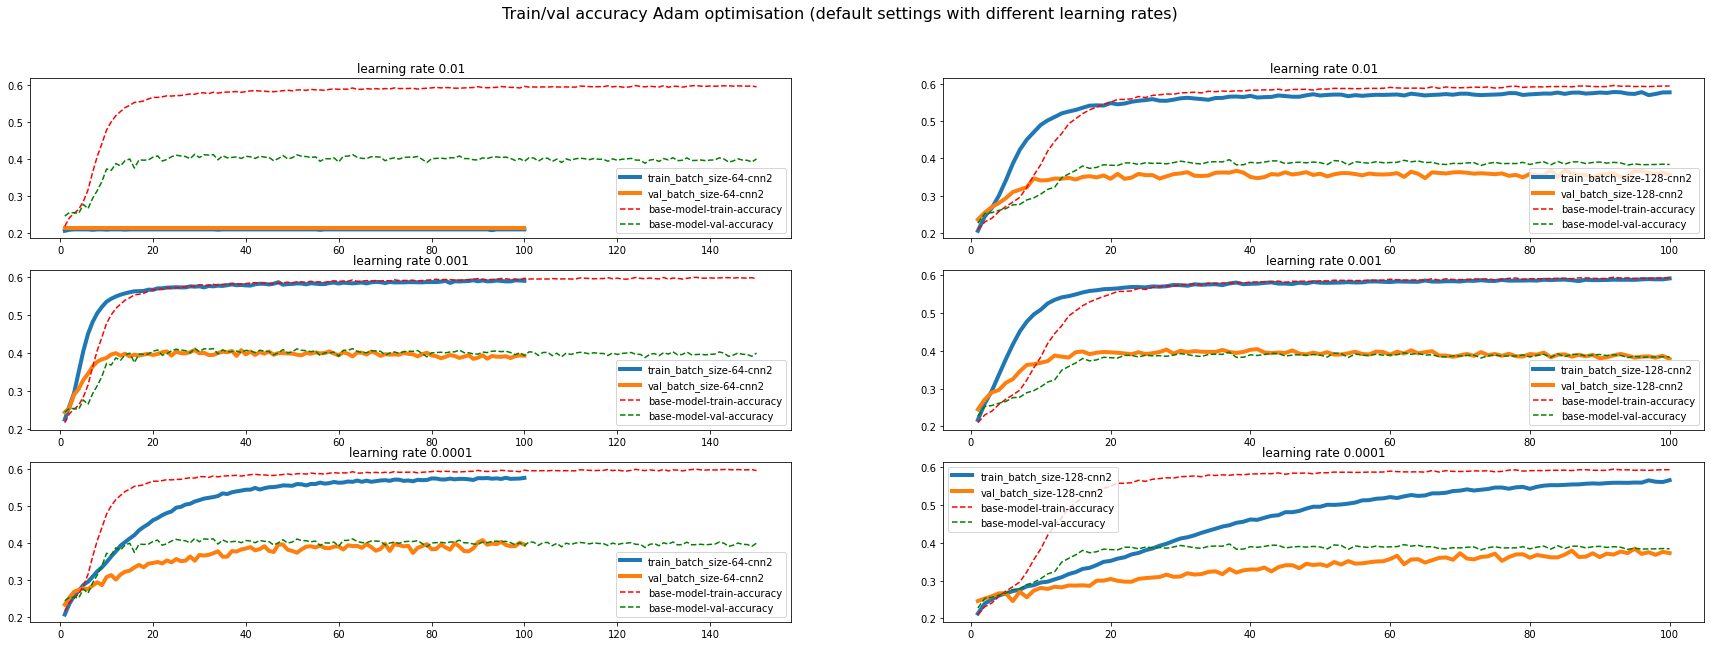

In [19]:
figure, axis = plt.subplots(3, 2)

figure.suptitle('Train/val accuracy Adam optimisation (default settings with different learning rates)', fontsize=16)

axis[0, 0].set_title("learning rate 0.01")
axis[0, 1].set_title("learning rate 0.01")
axis[1, 0].set_title("learning rate 0.001")
axis[1, 1].set_title("learning rate 0.001")
axis[2, 0].set_title("learning rate 0.0001")
axis[2, 1].set_title("learning rate 0.0001")

figure.set_figwidth(30)
figure.set_figheight(10)

for i in range(0,3):
    for j in range(0,2):
            axis[i, j].plot(df_a_6[2*i+j].epoch, df_a_6[2*i+j].train_accuracy, label= "train_batch_size-"+str(params[j]) + "-cnn2", linewidth=4)
            axis[i, j].plot(df_a_6[2*i+j].epoch, df_a_6[2*i+j].val_accuracy, label= "val_batch_size-"+str(params[j]) + "-cnn2", linewidth=4)
            axis[i, j].plot(df_a_3[j].epoch, df_a_3[j].train_accuracy, 'r--', label= "base-model-train-accuracy")
            axis[i, j].plot(df_a_3[j].epoch, df_a_3[j].val_accuracy, 'g--', label= "base-model-val-accuracy") 
            
            axis[i, j].legend()
        
plt.show()

The goal of Adam is to implement both momentum and RMS Prop to adaptively adjust the learning rate and speed up the learning process. This does happen with lr = 0.001 and 0.1 with batch size = 128. The model actually learns at a faster rate. The accuracy doesn't change much though and stagnates at a similar value. All other models had learning rates too high or too low. All hyperparameters and settings need to be tested with different properties and this is one of them. Clearly the models in the middle work the best. 

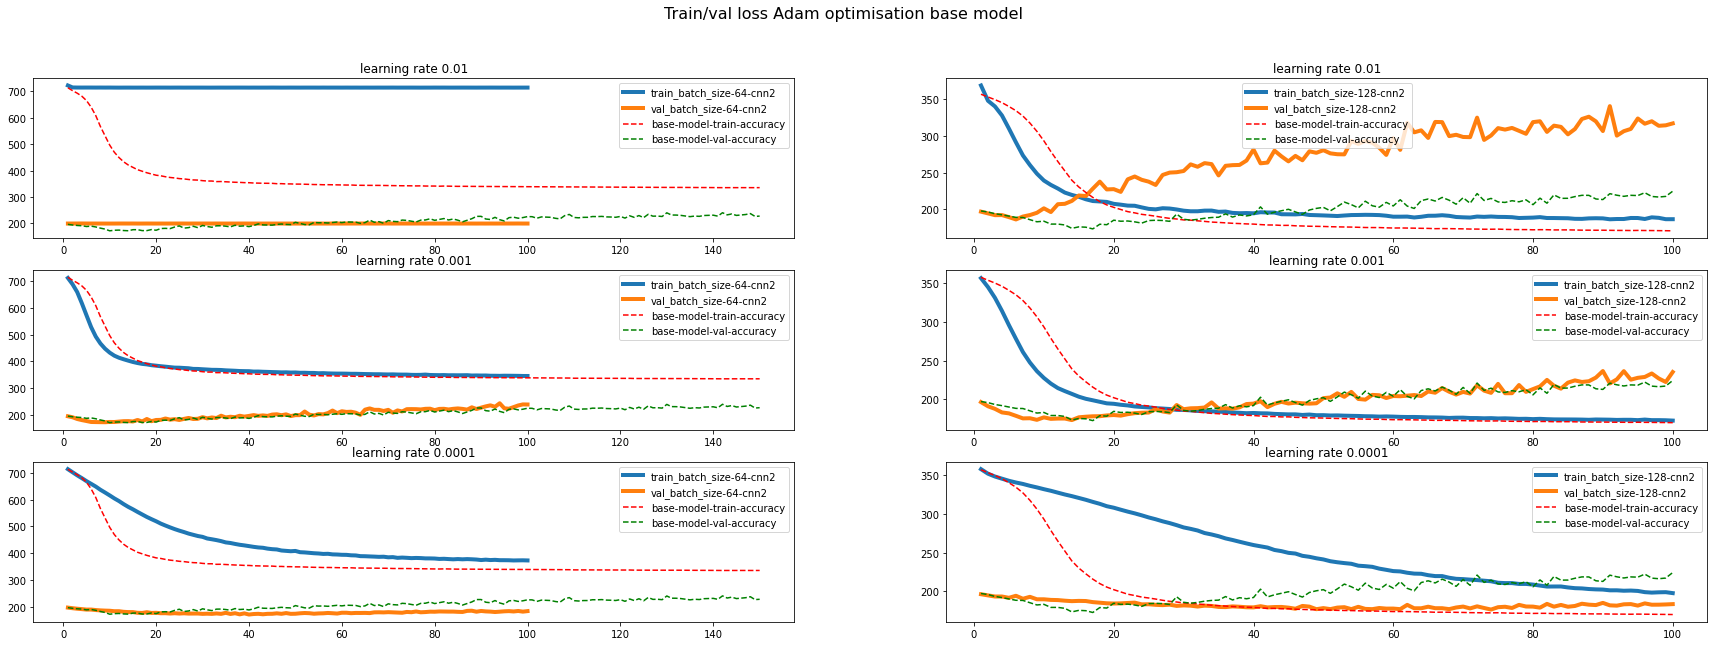

In [20]:
figure, axis = plt.subplots(3, 2)

figure.suptitle('Train/val loss Adam optimisation base model', fontsize=16)

axis[0, 0].set_title("learning rate 0.01")
axis[0, 1].set_title("learning rate 0.01")
axis[1, 0].set_title("learning rate 0.001")
axis[1, 1].set_title("learning rate 0.001")
axis[2, 0].set_title("learning rate 0.0001")
axis[2, 1].set_title("learning rate 0.0001")

figure.set_figwidth(30)
figure.set_figheight(10)

for i in range(0,3):
    for j in range(0,2):
            axis[i, j].plot(df_a_6[2*i+j].epoch, df_a_6[2*i+j].train_loss, label= "train_batch_size-"+str(params[j]) + "-cnn2", linewidth=4)
            axis[i, j].plot(df_a_6[2*i+j].epoch, 100*df_a_6[2*i+j].val_loss, label= "val_batch_size-"+str(params[j]) + "-cnn2", linewidth=4)
            axis[i, j].plot(df_a_3[j].epoch, df_a_3[j].train_loss, 'r--', label= "base-model-train-accuracy")
            axis[i, j].plot(df_a_3[j].epoch, 100*df_a_3[j].val_loss, 'g--', label= "base-model-val-accuracy") 
            
            axis[i, j].legend()
        
plt.show()

### Conclusion

Not a lot of improvement could be made by tuning the hyperparameters above and tweaking the base model. The model generally doesn't overfit too much, so regularization doesn't make that much of a difference. There is much more potential in using data augmentation and additional data (text data from the chat of the streamer, audio data) to combine everything into a multimodal neural network as it is described in the paper I took the data from. Sometimes the streamer interacts with the chat to create a more interactive viewer experience and depending on the game state the streamer might be a little bit "louder".

The best model could be achieved by simply adding more neurons to a fully connected layer. Due to a lack of time, I couldn't test how much the maximum amount of improvement is by adding more fully connected layers with more neurons.